## Tutorial for perturbation API

In [3]:
import numpy as np
import scanpy as sc 

from spatial_gnn.api.perturbation_api import (
    train_perturbation_model,
    predict_perturbation_effects, 
    get_perturbation_summary, 
    visualize_perturbation_effects, 
    create_perturbation_mask
)

In [4]:
train_data_path = "/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/data/raw/aging_coronal.h5ad"
test_data_path = "/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/data/raw/aging_coronal.h5ad" 

### Define and train perturbation model 

This requires defining the training arguments and supplying an anndata for the training dataset.

In [5]:
training_args = {
    "k_hop": 2,
    "augment_hop": 2,
    "center_celltypes": "T cell,NSC,Pericyte",
    "node_feature": "expression",
    "inject_feature": "None",
    "debug": True,
    "debug_subset_size": 10,
    "num_cells_per_ct_id": 100,
    "epochs": 10,
}

In [ ]:
print("=== Training a new perturbation model ===")
model, model_config, model_path = train_perturbation_model(
    adata_path=train_data_path,
    exp_name="aging_coronal",
    **training_args
)

=== Training a new perturbation model ===
Training new perturbation model from scratch...
Training on device: cuda
Starting dataset processing at 22:32:39
Dataset already exists at:  ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/test
Finished processing test dataset
Starting dataset processing at 22:32:39
Gene processing: 46.147s
Gene saving: 0.175s

Processing file 1/1: aging_coronal.h5ad
  File loading: 22.978s
  Cell type filtering: 2.175s
  Normalizing data


/users/abuen/miniconda3/envs/spatial/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Inference with perturbation model

Define set of perturbations in the form of a dictionary mapping `cell type` → `gene name` → `multiplier`. For instance, entry `'T cell': {'Igf2': 0.0},` indicates knockout of IGF2 in all T-cells in the input dataset.

In [ ]:
# Define perturbations
perturbation_dict = {
    'T cell': {'Igf2': 0.0},  
    'NSC': {'Sox9': 2.0},         
    'Pericyte': {'Ccl4': 0.5}    
}

In [ ]:
# Save perturbation mask to anndata
test_adata = sc.read_h5ad(test_data_path)
test_data_path_perturbed = create_perturbation_mask(test_adata, perturbation_dict, save_path=test_data_path)

In [ ]:
print("\n=== Predicting perturbation effects ===")
adata_perturbed = predict_perturbation_effects(
    adata_path=test_data_path_perturbed,
    model_path=model_path,
    exp_name="aging_sagittal",
    perturbation_dict=perturbation_dict,
    perturbation_mask_key="perturbation_mask"
)

In [3]:
result_path = "/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/data/perturbed/aging_coronal_perturbed_result.h5ad"

In [4]:
import scanpy as sc 

adata_result = sc.read_h5ad(result_path)

In [5]:
adata_result

AnnData object with n_obs × n_vars = 1453144 × 300
    obs: 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'transcript_count', 'num_detected_genes', 'barcodeCount', 'mouse_id', 'slide_id', 'cohort', 'age', 'batch', 'celltype', 'region', 'subregion'
    uns: 'neighbors', 'pca', 'perturbation_info', 'umap'
    obsm: 'X_pca', 'X_umap', 'perturbation_mask', 'spatial'
    varm: 'PCs'
    layers: 'perturbation_effects', 'predicted_perturbed'
    obsp: 'connectivities', 'distances'

In [6]:
effects = adata_result.layers['perturbation_effects']

In [9]:
import numpy as np 

mean_effects = np.abs(np.mean(effects, axis=0))

In [10]:
mean_effects

array([3.96494639e-01, 2.54309087e-01, 1.15253659e+00, 1.91592693e+00,
       1.35103036e-01, 3.74213183e-01, 5.19641259e+00, 3.94202034e+00,
       2.92678387e+00, 3.68497493e-02, 2.61213320e-01, 5.37126533e-02,
       9.66689339e-01, 3.68369755e-01, 2.38921958e+00, 8.05380280e-01,
       1.88134566e+00, 3.87262002e+00, 7.27804884e-01, 2.36225185e-01,
       5.96902302e-02, 2.21386221e-01, 7.06650310e-02, 1.71865704e-01,
       5.33596604e-02, 1.10126172e-01, 1.85715124e+00, 1.00169242e-01,
       5.10875051e-02, 7.63042445e-02, 6.40665693e-01, 4.86838187e-01,
       2.47583556e-01, 2.59269971e-01, 7.95247410e-01, 7.60746747e-01,
       5.55067013e-01, 1.65634321e-01, 1.88825411e+00, 4.81374102e-01,
       5.66788156e-02, 5.59702747e-02, 9.92970960e-02, 7.42937887e-01,
       6.51616643e-02, 7.46076499e-02, 3.88734545e+00, 3.52032211e-01,
       8.28851507e+00, 3.14200876e-02, 1.15172658e+00, 3.04454209e-01,
       1.52963712e+00, 2.80626901e+00, 2.49936839e-01, 4.77077607e+00,
      

In [12]:
effects = adata_result.layers['perturbation_effects']

In [13]:
summary_stats = {
    'mean_effect': np.mean(effects, axis=0),
    'std_effect': np.std(effects, axis=0),
    'max_effect': np.max(effects, axis=0),
    'min_effect': np.min(effects, axis=0),
    'median_effect': np.median(effects, axis=0),
    'num_perturbed_cells': np.sum(effects != 0)
}

In [14]:
import pandas as pd


summary_df = pd.DataFrame(summary_stats, index=adata_result.var_names)

In [15]:
summary_df

,mean_effect,std_effect,max_effect,min_effect,median_effect,num_perturbed_cells
Igf2,-0.396495,2.508915,0.0,-144.000000,0.0,141046407
Th,-0.254309,2.142394,0.0,-181.000000,0.0,141046407
Pdgfra,-1.152537,6.135412,0.0,-159.000000,0.0,141046407
Sox9,-1.915927,3.713658,0.0,-105.290711,-1.0,141046407
Cd52,-0.135103,0.406465,0.0,-16.000000,0.0,141046407
...,...,...,...,...,...,...
Rsph3a,-0.057183,0.245123,0.0,-9.000000,0.0,141046407
Cdkn1a,-0.802927,1.839261,0.0,-98.000000,0.0,141046407
Sod2,-2.297315,2.903648,0.0,-47.000000,-1.0,141046407
Gal,-0.069077,0.301036,0.0,-33.000000,0.0,141046407


In [16]:
mean_effects = np.abs(np.mean(effects, axis=0))

In [18]:
top_indices = np.argsort(mean_effects)[-20:]

In [20]:
genes = adata_result.var_names[top_indices].tolist()

In [21]:
genes

['Clu',
 'Tubb3',
 'Enpp2',
 'Cd47',
 'Cfl1',
 'Stmn2',
 'Neat1',
 'Cdk5r1',
 'Slc32a1',
 'Aldoc',
 'Gad2',
 'Apoe',
 'Syt11',
 'Gad1',
 'Atp1a2',
 'Gpm6b',
 'Snhg11',
 'Spock2',
 'Slc17a7',
 'Slc1a2']

In [22]:
gene_effects = np.mean(effects, axis=0)

In [ ]:
gene_indices = [adata_result.var_names.get_loc(gene) for gene in genes if gene in adata_result.var_names]

<BarContainer object of 20 artists>

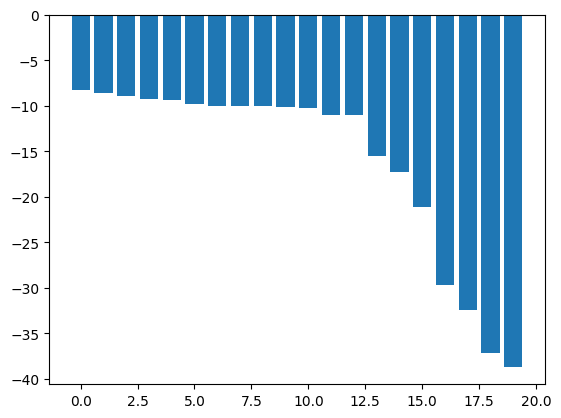

In [25]:
import matplotlib.pyplot as plt

plt.bar(range(len(gene_indices)), gene_effects[gene_indices])

AttributeError: module 'matplotlib.pyplot' has no attribute 'xticklabels'

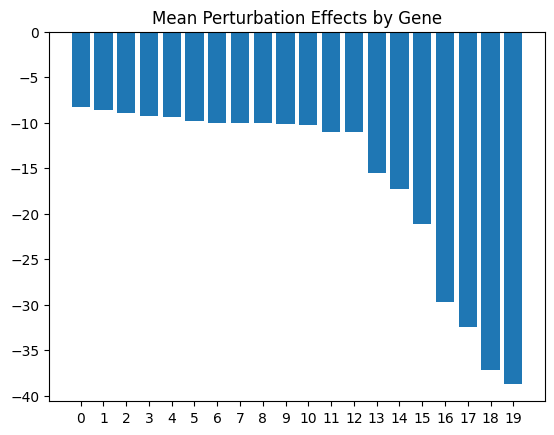

In [26]:
    plt.bar(range(len(gene_indices)), gene_effects[gene_indices])
    plt.title('Mean Perturbation Effects by Gene')
    plt.xticks(range(len(gene_indices)))
    plt.xticklabels(genes, rotation=45)